# Data Exploration
In this notebook, we present some of the results of our data exploration.  We look at the training data, figure out an appropriate size to crop the data, and investigate how the steering angle should change as a function of camera offset.  We take it as a challenge to only use the dataset provided by Udacity for this project.  This data is from the car driving around the track clockwise, thus we will have to generalize from this data to driving around the track counter-clockwise.

In [1]:
import pickle
import numpy as np
import pandas as pd
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_log = pd.read_csv('./data/driving_log.csv')

## Question 1: What is the distribution of steering angles?

In [3]:
steer = data_log['steering']

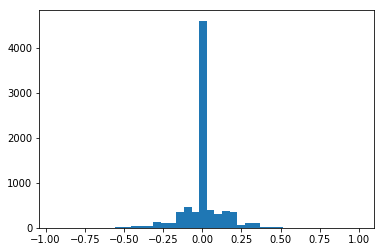

In [4]:
n,bins,patches = plt.hist(steer,40)

## Question 2: How well does a prediction of 0 do?
We see that the vast majority of the data has a steering angle very close to 0.  As a baseline to judge our models against, let's look at the MSE of a constant prediction of 0.

In [5]:
num_measurements = steer.size
print(num_measurements)

8036


In [6]:
steer = np.asarray(steer)

In [7]:
np.sum((steer > -0.01) * (steer < 0.01))

4452

In [8]:
mse_0 = np.dot(steer,steer)/num_measurements
print(mse_0)

0.0166142606091


### Conclusion
Out of 8036 steering measurements, 4452 are between -0.01 and 0.01.  Always predicting a steering angle of 0 gives a mean squared error of 0.0166.

## Question 3: How was the Udacity data collected?
Let's look at a plot of the sequence of steering values from the Udacity data.

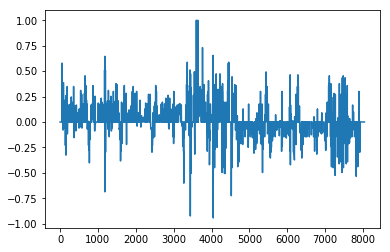

In [91]:
plt.plot(range(steer.size),steer)

The data seems to be quite jumpy, which probably indicates it was taken from a keyboard.  Let's look at the difference between steering angles at time t and t-1.

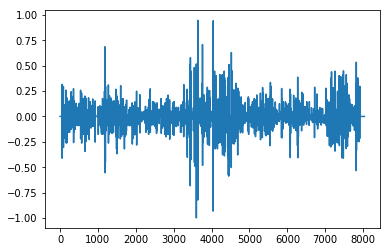

In [94]:
diff = steer[1:]-steer[:-1]
plt.plot(range(diff.size),diff)

In [96]:
np.max(diff)

0.94780863000000004

We see there are moments where the steering angle differs radically from one time step to the next.  As the images from one time step to the next are likely very similar, this will also cause difficulties for our model.

## Question 4: Where should we crop the images?
Let's look at some random images from the data set and decide on our cropping scheme.

In [9]:
center_path = data_log['center']

In [10]:
num_examples = 8
indices = np.random.randint(center_path.size,size=num_examples)

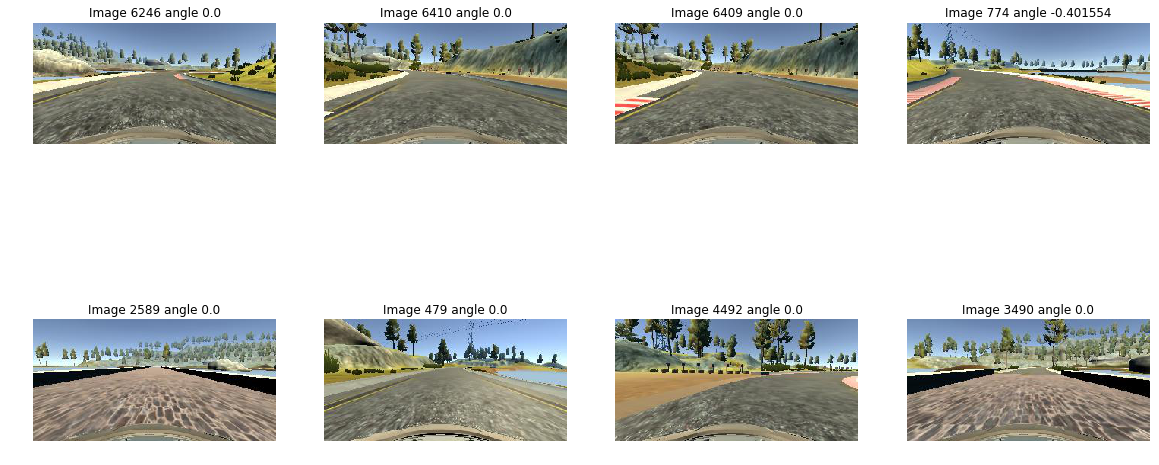

In [11]:
plt.figure(figsize = (20,10))
for i in range(num_examples):
    path = './data/'+center_path[indices[i]]
    imgpil = Image.open(path)
    img = np.asarray(imgpil)
    plt.subplot(2,4,i+1)
    plt.axis('off')
    title_string = 'Image '+str(indices[i])+' angle '+str(steer[indices[i]])
    plt.title(title_string)
    plt.imshow(img)

We compare two crops of the top of the image, at 50 and 60 pixels.  We crop the bottom 25 pixels of the image to remove the car hood.

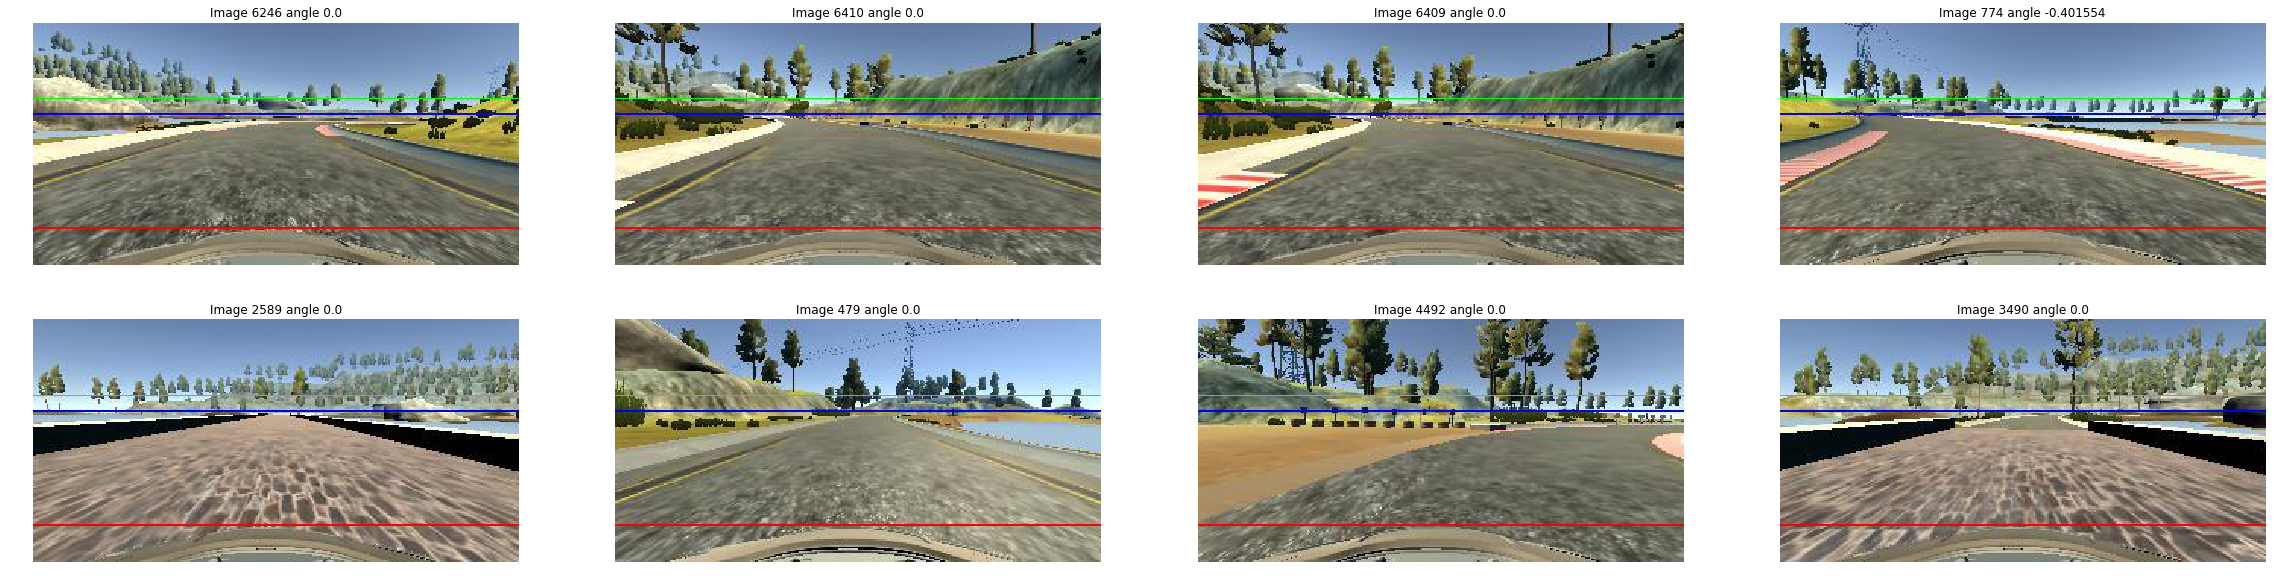

In [12]:
plt.figure(figsize = (40,10))
for i in range(num_examples):
    path = './data/'+center_path[indices[i]]
    imgpil = Image.open(path)
    img = np.asarray(imgpil)
    cv2.line(img, (0,135),(320,135),(255,0,0))
    cv2.line(img, (0,50),(320,50),(0,255,0))
    cv2.line(img, (0,60),(320,60),(0,0,255))
    plt.subplot(2,4,i+1)
    plt.axis('off')
    title_string = 'Image '+str(indices[i])+' angle '+str(steer[indices[i]])
    plt.title(title_string)
    plt.imshow(img)

Let's get a closer look to decide the top crop.

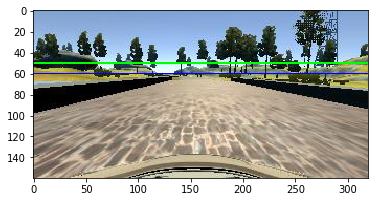

In [13]:
path = './data/'+center_path[0]
imgpil = Image.open(path)
img = np.asarray(imgpil)
cv2.line(img, (0,50),(320,50),(0,255,0))
cv2.line(img, (0,60),(320,60),(0,0,255))
plt.imshow(img)

While the crop at 60 seems to include the entire road, we decide to crop at 55 to be on the safe side and ensure that we still see enough of the road when going over a bump.

The original height of the image is 160.  Cropping out the top 55 pixels and bottom 25 pixels leaves us with an image height 80, half the original height.

### Conclusion
We will crop to img[55:135,:].  This gives us an image of size 80-by-320.

## Question 5: What is the pixel offset of the left and right cameras?
We want to use the left and right camera images to create more images with nonzero steering angles.  To use them, we need to decide how much the original steering angle should be offset when using a shifted view of the image.  As a first step in determining this, we look at the pixel shift of the left and right cameras compared to the center camera.

In [14]:
left_path = data_log['left']
right_path = data_log['right']

In [15]:
num_examples = 2
indices = np.random.randint(center_path.size,size=num_examples) 

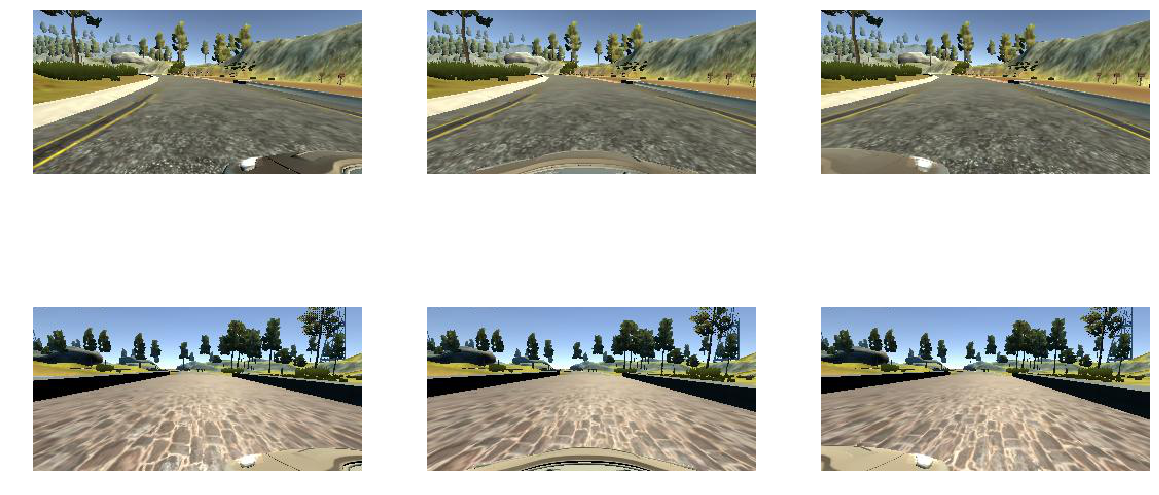

In [16]:
plt.figure(figsize=(20,10))
for i in range(num_examples):
    path = './data/'+center_path[indices[i]]
    imgpil = Image.open(path)
    img_center = np.asarray(imgpil)
    path = './data/'+left_path[indices[i]][1:]
    imgpil = Image.open(path)
    img_left = np.asarray(imgpil)
    path = './data/'+right_path[indices[i]][1:]
    imgpil = Image.open(path)
    img_right = np.asarray(imgpil)
    plt.subplot(num_examples,3,3*i+1)
    plt.axis('off')
    plt.imshow(img_left)
    plt.subplot(num_examples,3,3*i+2)
    plt.axis('off')
    plt.imshow(img_center)
    plt.subplot(num_examples,3,3*i+3)
    plt.axis('off')
    plt.imshow(img_right)

### Key observation
The pixel offset depends on the row number!  The trees in the background are almost in the same place in all three images.  The lane markings close to the car, however, have a large offset of around 50 pixels.  The 2D picture is reflecting the 3D world where objects far away have less change in their position as we move our head compared to objects that are close.

Now we will try to determine the pixel shift as a function of the row number.  The idea being that objects with smaller row number are generally further away in these images.

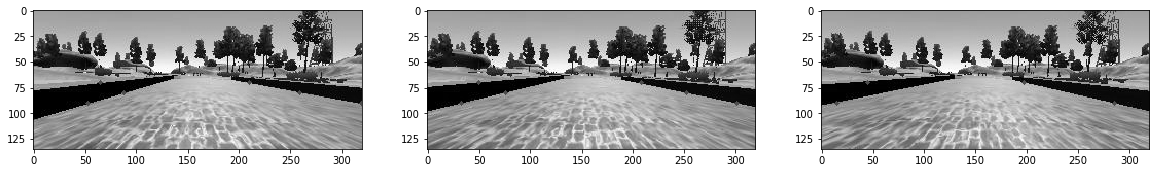

In [97]:
plt.figure(figsize=(20,10))
rgb2gray = np.array([.299,.587,.114])
gray_left = np.einsum('ijk,k -> ij',img_left[:135,:],rgb2gray)
gray_center = np.einsum('ijk,k -> ij',img_center[:135,:],rgb2gray)
gray_right = np.einsum('ijk,k -> ij',img_right[:135,:],rgb2gray)
plt.subplot(1,3,1)
plt.imshow(gray_left,cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(gray_center,cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(gray_right,cmap = 'gray')

The plan is to look at rows of the matrix and "match up" the pixels from the left, center, and right cameras.  We will do this for several different row numbers to see how the offset changes as a function of the row number.

We start at the bottom, looking at row number 125.  The offset between the left and center cameras at row 125 looks to be about 42 pixels.  

In [17]:
rgb2gray = np.array([0.299,0.587,0.114])
gray_left = np.einsum('ijk,k->ij',img_left,rgb2gray)
gray_center = np.einsum('ijk,k->ij',img_center,rgb2gray)
gray_right = np.einsum('ijk,k->ij',img_right,rgb2gray)

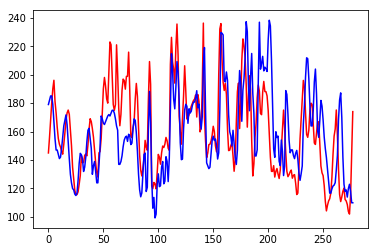

In [18]:
offset = 42
plt.plot(range(320-offset),gray_left[125,offset:],'r',range(320-offset),gray_center[125,:320-offset],'b')

The offset between the center and right cameras looks to be about the same.

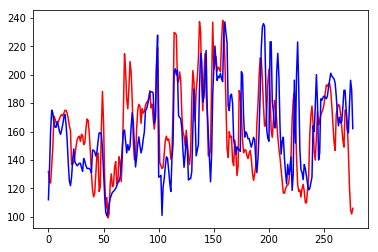

In [19]:
offset = 43
plt.plot(range(320-offset),gray_center[125,offset:],'r',range(320-offset),gray_right[125,:320-offset],'b')

Now we look at row number 105.  The offset seems to be about 29.

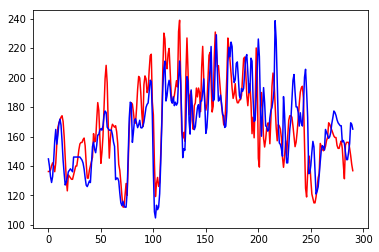

In [20]:
offset = 29
plt.plot(range(320-offset),gray_left[105,offset:],'r',range(320-offset),gray_center[105,:320-offset],'b')

A value of 29 matches up pretty well for the offset between the center and right cameras.

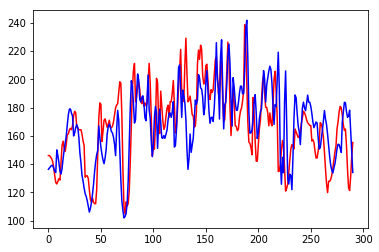

In [21]:
offset = 29
plt.plot(range(320-offset),gray_center[105,offset:],'r',range(320-offset),gray_right[105,:320-offset],'b')

From here on out, we will just look at the left and center cameras and assume the same offset holds between the center and right cameras.  We look at row number 85.  An offset of 16 matches up pretty well.

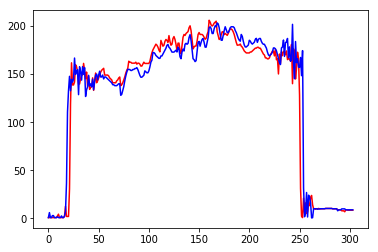

In [22]:
offset = 16
plt.plot(range(320-offset),gray_left[85,offset:],'r',range(320-offset),gray_center[85,:320-offset],'b')

Already at row number 65, the offset becomes quite small, about 3 pixels.

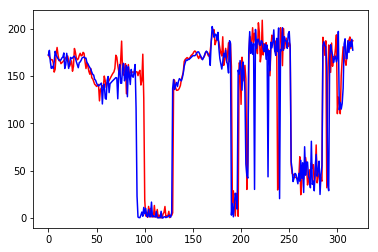

In [23]:
offset = 3
plt.plot(range(320-offset),gray_left[65,offset:],'r',range(320-offset),gray_center[65,:320-offset],'b')

The data we have collected so far of the pixel offset as a function of row number is (125,42),(105,29),(85,16),(65,3).  Amazingly, this data is perfectly fit by a line!  for every 20 pixel change in row coordinate, the shift changes by 13 pixels.  Let's check this hypothesis by collecting some more data.

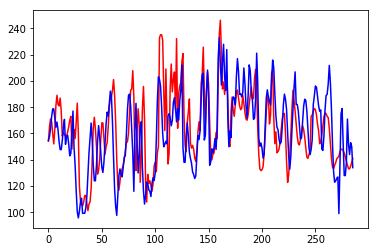

In [24]:
offset = 34
plt.plot(range(320-offset),gray_left[115,offset:],'r',range(320-offset),gray_center[115,:320-offset],'b')

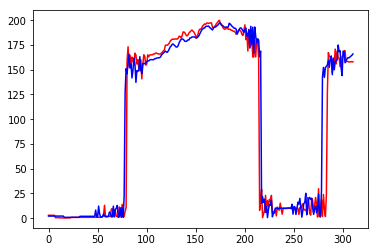

In [25]:
offset = 9
plt.plot(range(320-offset),gray_left[75,offset:],'r',range(320-offset),gray_center[75,:320-offset],'b')

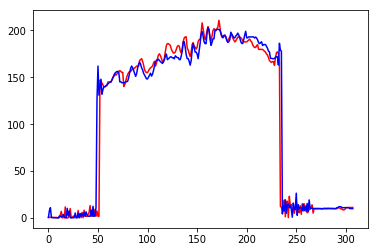

In [26]:
offset = 12
plt.plot(range(320-offset),gray_left[80,offset:],'r',range(320-offset),gray_center[80,:320-offset],'b')

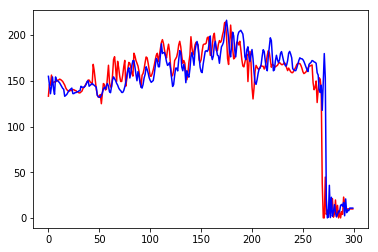

In [27]:
offset = 20
plt.plot(range(320-offset),gray_left[90,offset:],'r',range(320-offset),gray_center[90,:320-offset],'b')

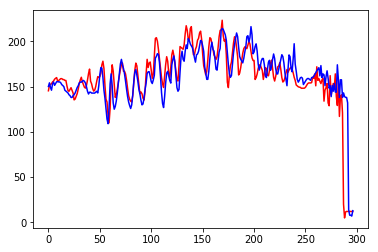

In [28]:
offset = 23
plt.plot(range(320-offset),gray_left[95,offset:],'r',range(320-offset),gray_center[95,:320-offset],'b')

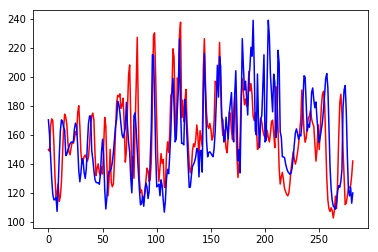

In [29]:
offset = 38
plt.plot(range(320-offset),gray_left[120,offset:],'r',range(320-offset),gray_center[120,:320-offset],'b')

### Plotting the offset as a function of row number
Now that we have collected some data points, let's plot them and draw some conclusions.

-38.6916269571
0.641797140912


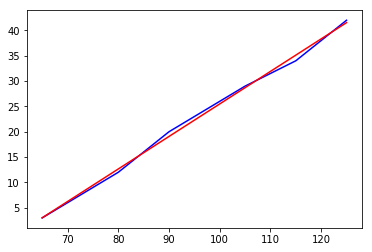

In [30]:
rows = np.array([65,75,80,85,90,95,105,115,120,125])
offsets = np.array([3,9,12,16,20,23,29,34,38,42])
A = np.hstack((np.ones((10,1)),rows[:,None]))
c,m = np.linalg.lstsq(A, offsets)[0]
print(c)
print(m)
plt.plot(rows,offsets,'b',[65,125],[c+65*m, c+125*m],'r')

### Conclusion
A linear fit is indeed quite good!  The slope is about 0.64 and offset about -38.69.  Now we can determine the pixel offset of the left and right cameras at any point in the image.  Next we apply this to determining how the steering angle should change for an image from the left or right camera.

## Question 6: How should the steering angle change for left and right camera images?
To figure this out, we use a basic model.  From a center camera image, we locate the point in the road that the driver wants to steer towards.  We then locate this same point in the left camera image and determine the steering angle.  Some pictures will make this idea more clear.

In [31]:
print(np.max(steer))
print(np.argmax(steer))

1.0
3598


Let's look at the image with the largest steering angle in the dataset.  From the forums we learned that the units used in the data set is 25 degrees, i.e. a steering value of 1.0 corresponds to a steering angle of 25 degrees.

1.0


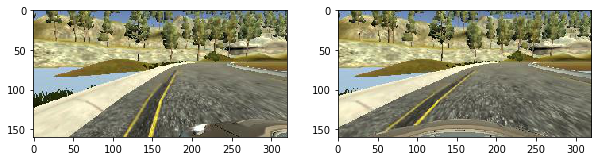

In [32]:
index = 3598
path = './data/'+center_path[index]
imgpil = Image.open(path)
img_center = np.asarray(imgpil)
path = './data/'+left_path[index][1:]
imgpil = Image.open(path)
img_left = np.asarray(imgpil)
angle = steer[index]
print(angle)
plt.figure(figsize = (10,20))
plt.subplot(1,2,1)
plt.imshow(img_left)
plt.subplot(1,2,2)
plt.imshow(img_center)

Let's try to guess where the driver is targeting to go by looking at a line at a 25 degree angle from the center of the hood.

In [33]:
def draw_angle(index,angle):
    path = './data/'+center_path[index]
    imgpil = Image.open(path)
    img = np.asarray(imgpil)
    angle_radians = 25*angle*np.pi/180
    y_dist = 120
    x_offset = int(round(y_dist * np.tan(angle_radians)))
    cv2.line(img,(160,160),(160+x_offset,160-y_dist),(255,0,0))
    return(img)

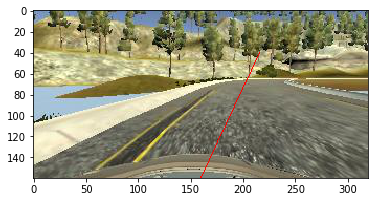

In [34]:
img_copy = draw_angle(3598,steer[3598])
plt.imshow(img_copy)

In [35]:
angle2 = np.min(steer)
index2 = np.argmin(steer)
print(angle2)
print(index2)

-0.9426954
4043


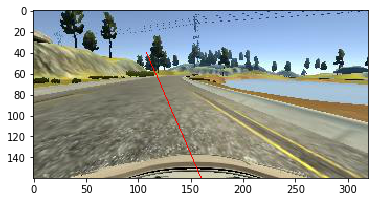

In [36]:
img_copy = draw_angle(4043,steer[4043])
plt.imshow(img_copy)

Let's assume for the moment that the driver is looking ahead on the road to row 80.  The offset for the left camera we calculated for row 80 is about 13.  

In [37]:
def compare_angles(index):
    path = './data/'+center_path[index]
    imgpil = Image.open(path)
    img_center = np.asarray(imgpil)
    path = './data/'+left_path[index][1:]
    imgpil = Image.open(path)
    img_left = np.asarray(imgpil)
    path = './data/'+right_path[index][1:]
    imgpil = Image.open(path)
    img_right = np.asarray(imgpil)
    angle = 25*steer[index]*np.pi/180
    x_offset = int(round(80*np.tan(angle)))
    left_offset = x_offset + 13
    left_angle = np.arctan(left_offset/80)
    right_offset = x_offset - 13
    right_angle = np.arctan(right_offset/80)
    cv2.line(img_center,(160,160),(160+x_offset,80),(255,0,0),2)
    cv2.line(img_left,(160,160),(160+left_offset,80),(255,0,0),2)
    cv2.line(img_right,(160,160),(160+right_offset,80),(255,0,0),2)
    plt.figure(figsize=(15,20))
    plt.subplot(1,3,1)
    plt.title(left_angle)
    plt.imshow(img_left)
    plt.subplot(1,3,2)
    plt.title(angle)
    plt.imshow(img_center)
    plt.subplot(1,3,3)
    plt.title(right_angle)
    plt.imshow(img_right)

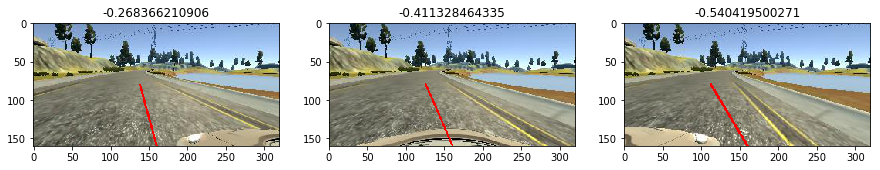

In [38]:
compare_angles(4043)

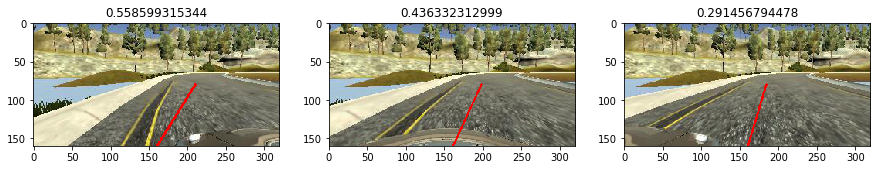

In [39]:
compare_angles(3598)

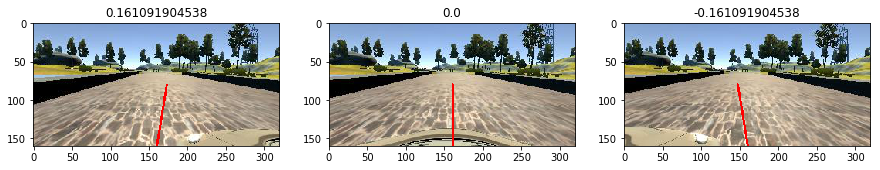

In [40]:
compare_angles(0)

We see that with this setup, the left, center, and right images are all steering towards the same point on the road.  This also seems to be giving reasonable steering directions for the left and right cameras.  Finally, we notice that the change in angle for the left and right cameras is a function of the center camera angle.  Next we see what exactly this function is.

In [41]:
# maximum steering angle in radians
max_angle = 25*np.pi/180

In [42]:
angle_array= np.linspace(-max_angle,max_angle,40)

In [43]:
def new_angle(angle):
    return np.arctan(np.tan(angle)+13/80)

In [44]:
new_angle_array = new_angle(angle_array)

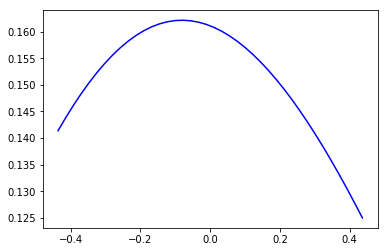

In [45]:
plt.plot(angle_array,new_angle_array - angle_array,'b')

In [46]:
diff = new_angle_array - angle_array
max_diff = np.max(diff)-np.min(diff)
(max_diff*180/np.pi)/25

0.085123611771023774

In terms of the units used in the training data, the difference in the angle offset changes by 0.08 over the range of steering angles.  This seems fairly significant, so we will go ahead and use a variable offset.

Here is a plot of the offset in terms of the units used in the training data

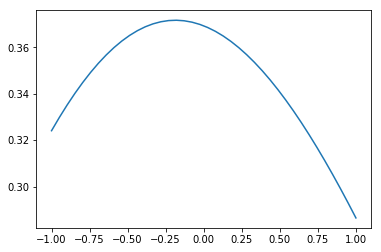

In [47]:
t_diff = (diff*180/np.pi)/25
t_angles = (angle_array*180/np.pi)/25
plt.plot(t_angles,t_diff)

### Conclusion
We decided that a driver is looking at the road around row 80 to make their decisions about the steering angle.  As the pixel offset for the left camera at row 80 is about 13, a given (x,y) pixel in the center camera is located at (x+13,y) in the left camera image.  This means that, from the point of view of the left camera, steering to the same spot the center driver is steering to will result in an angle np.arctan(np.tan(angle) + 13/80).  This is the transformation we will use to transform our the angles in the dataset for the left camera.

## Question 7: What is the effect of the focal point on the offset angle?
Thus far we made the **assumption** that the driver was looking ahead on the road out to about row 80 to determine the steering angle.  This gives quite a large offset angle at low angles that results in a zig zag driving behavior.  Let's look at different choices of this "focal point" of the driver and see what the effect on the offset angle is.

In [75]:
def new_angle(angle,target_dist):
    x_offset = -38.69 + .64*target_dist
    angle_radians = np.arctan(np.tan(angle) + x_offset/(160-target_dist))
    return (angle_radians*180/np.pi)/25

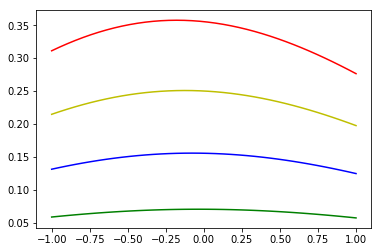

In [74]:
udacity_units = (angle_array*180/np.pi)/25
offset80 = new_angle(angle_array,80) - udacity_units
offset75 = new_angle(angle_array,75) - udacity_units
offset70 = new_angle(angle_array,70) - udacity_units
offset65 = new_angle(angle_array,65) - udacity_units
plt.plot(udacity_units,offset80,'r',udacity_units, offset75,'y',udacity_units,offset70,'b',udacity_units,offset65,'g')

## Question 8: How should we resize images?
After cropping, our images are of size 80-by-320.  

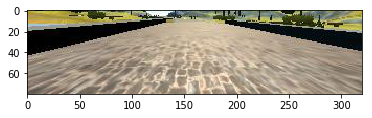

In [50]:
path = './data/'+center_path[0]
imgpil = Image.open(path)
img = np.asarray(imgpil)
img = img[55:135,:]
plt.imshow(img)

We will resize the images so that they take less memory and training is faster.  After experimenting with some different sizes, we decided to reduce the height to 8 and the width to 64.  The images now look as follows.

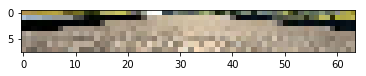

In [98]:
img_small = cv2.resize(img,(64,8))
plt.imshow(img_small)

## Question 9: Is there more to the story of offset angle?
Above we developed a simple model of the the left and center camera images differ.  This model does not seem to be the whole story however.  Pixel shift is not simply a function of row number, but also depends on if a pixel is on the left or right side of the image.  We could see this above as our plots did not completely "match" across the entire image.  

In this part we develop a more accurate model of how the left image can be obtained from the center one, using the cv2 function getPerspectiveTransform.

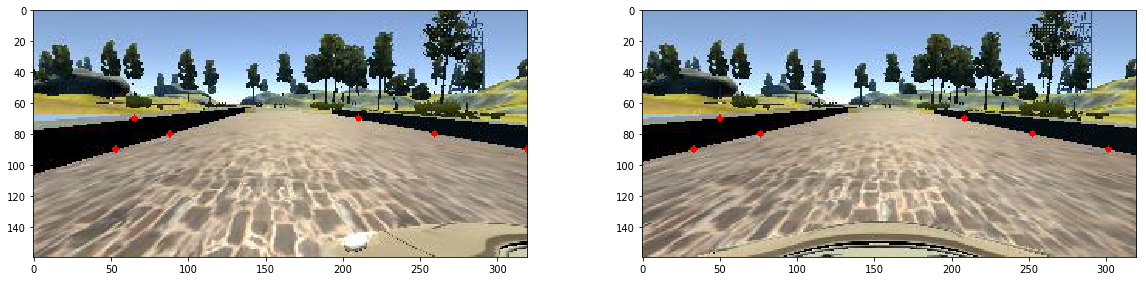

In [99]:
plt.figure(figsize = (20,10))
path = './data/'+center_path[0]
imgpil = Image.open(path)
img_center = np.asarray(imgpil)
path = './data/'+left_path[0][1:]
imgpil = Image.open(path)
img_left = np.asarray(imgpil)
path = './data/'+right_path[0][1:]
imgpil = Image.open(path)
img_right = np.asarray(imgpil)
# row 70
cv2.circle(img_left,(65,70),2,(255,0,0),-1)
cv2.circle(img_left,(210,70),2,(255,0,0),-1)
cv2.circle(img_center,(50,70),2,(255,0,0),-1)
cv2.circle(img_center,(208,70),2,(255,0,0),-1)
# row 80
cv2.circle(img_left,(88,80),2,(255,0,0),-1)
cv2.circle(img_left,(259,80),2,(255,0,0),-1)
cv2.circle(img_center,(76,80),2,(255,0,0),-1)
cv2.circle(img_center,(252,80),2,(255,0,0),-1)
# row 90
cv2.circle(img_left,(53,90),2,(255,0,0),-1)
cv2.circle(img_left,(319,90),2,(255,0,0),-1)
cv2.circle(img_center,(33,90),2,(255,0,0),-1)
cv2.circle(img_center,(301,90),2,(255,0,0),-1)
plt.subplot(2,2,1)
plt.imshow(img_left)
plt.subplot(2,2,2)
plt.imshow(img_center)

We have identified the location of six points from the center image in the left image.  We can now feed this information into getPerspectiveTransform to find a transformation that takes the center image to the left image.

In [60]:
src = np.array([[50,70],[208,70],[33,90],[301,90]],dtype = np.float32)
dst = np.array([[65,70],[210,70],[53,90],[319,90]],dtype = np.float32)
dst_right = np.array([[45,70],[197,70],[15,90],[285,90]],dtype = np.float32)
M = cv2.getPerspectiveTransform(src,dst)
M_right = cv2.getPerspectiveTransform(src,dst_right)
print(M)

[[  7.26146547e-01  -1.55791099e-02   1.62144175e+01]
 [  1.57469524e-15   5.22855637e-01   1.87875593e+01]
 [  3.44573003e-17  -2.98215227e-03   1.00000000e+00]]


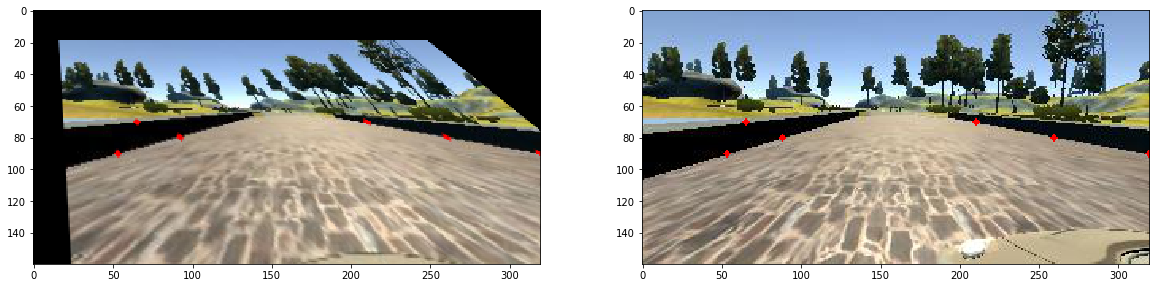

In [61]:
warped = cv2.warpPerspective(img_center, M, (320, 160))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.subplot(1,2,2)
plt.imshow(img_left)

These images show the left camera angle and the transformation of the center angle.  It is not perfect as there is some shearing of the trees in the background, but it looks pretty good.  We can now use this transformation to compute the offset angle for the left camera image, and compare this with our technique above.

In [62]:
def left_angle(angle):
    focal_point = 80
    # convert to radians
    angle = angle*25*np.pi/180
    offset = (160-focal_point)*np.tan(angle)
    initial = np.array([160+offset,(160-focal_point),1])
    vec = np.dot(M,initial)
    final = np.array([vec[0]/vec[2],vec[1]/vec[2]])
    new_angle = np.tan((final[0]-160.)/(160.-final[1]))
    # convert to udacity units
    new_angle = (new_angle*180/np.pi)/25
    return new_angle

In [63]:
def shear_method(angle):
    focal_point = 80
    # convert to radians
    angle = angle*25*np.pi/180
    x_offset = -38.69 + .64*focal_point
    angle_radians = np.arctan(np.tan(angle) + x_offset/focal_point)
    return (angle_radians*180/np.pi)/25

In [65]:
angles = np.linspace(-1,1,40)
new_angles = left_angle(angles)
first_method = shear_method(angles)

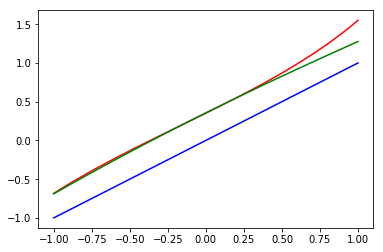

In [66]:
plt.plot(angles, new_angles,'r',angles,angles,'b',angles,first_method,'g')

The two methods are actually very similar across a wide spectrum of angles!  This is encouraging that we are on the right track.

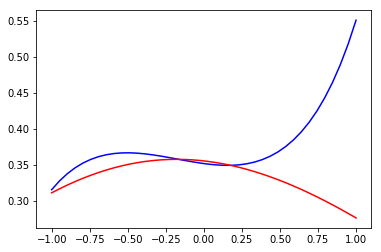

In [67]:
plt.plot(angles,new_angles-angles,'b',angles,first_method-angles,'r')

Now let's see how the two methods compare on real images.  We make a function to help with this.

In [68]:
def compare_methods(index):
    path = './data/'+left_path[index][1:]
    imgpil = Image.open(path)
    img_left = np.asarray(imgpil)
    angle = 25*steer[index]*np.pi/180
    x_offset = int(round(80*np.tan(angle)))
    left_offset = x_offset + 13
    left_angle = np.arctan(left_offset/80)
    cv2.line(img_left,(160,160),(160+left_offset,80),(255,0,0),2)
    initial = np.array([160+x_offset,80,1])
    vec = np.dot(M,initial)
    final = np.array([vec[0]/vec[2],vec[1]/vec[2]])
    final = np.round(final).astype(np.int32)
    cv2.line(img_left,(160,160),(final[0],final[1]),(0,255,0),2)
    plt.imshow(img_left)

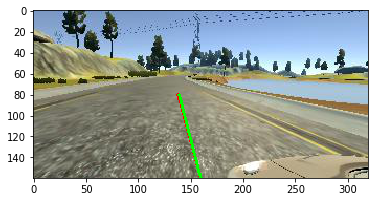

In [69]:
compare_methods(4043)

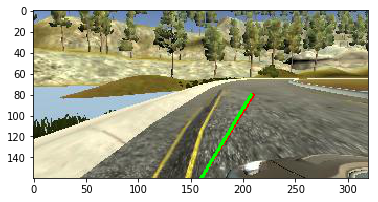

In [70]:
compare_methods(3598)

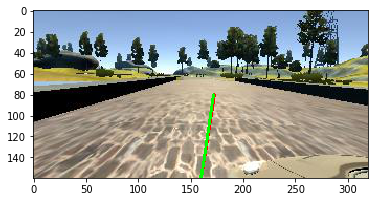

In [71]:
compare_methods(0)

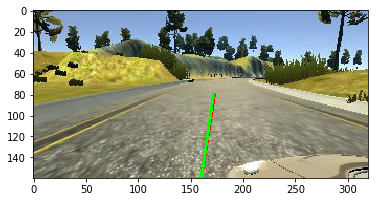

In [72]:
compare_methods(567)

On real images the two methods give very similar answers!

## What do your predictions look like?
Let's look at some predictions of our model on images from the training set.

In [102]:
from keras.models import load_model
import h5py
model = load_model('best_so_far.h5')

Using TensorFlow backend.


In [115]:
angle = float(model.predict(img_predict[None,:,:,:], batch_size=1))
print(angle)

-0.07336287945508957


In [129]:
def draw_prediction(index):
    path = './data/'+center_path[index]
    imgpil = Image.open(path)
    img = np.asarray(imgpil)
    img_predict = img[55:135,:]
    img_predict = cv2.resize(img_predict,(64,16))
    angle = float(model.predict(img_predict[None,:,:,:], batch_size=1))
    angle_radians = angle*25*np.pi/180
    x_offset = int(round(80*np.tan(angle_radians)))
    cv2.line(img,(160,160),(160+x_offset,80),(255,0,0),2)
    plt.title(angle)
    plt.axis('off')
    plt.imshow(img)

0.0


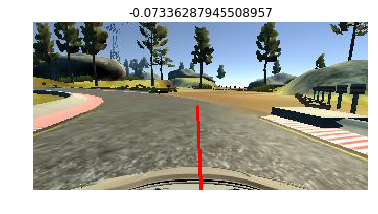

In [130]:
draw_prediction(15)
print(steer[15])

0.0


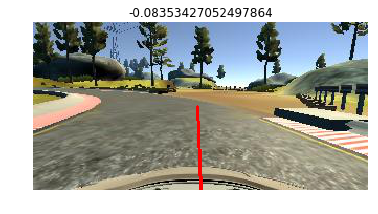

In [131]:
draw_prediction(20)
print(steer[20])

0.0


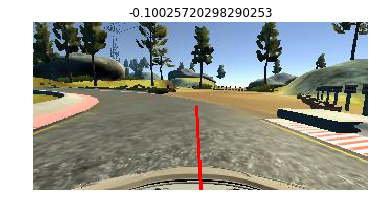

In [132]:
draw_prediction(25)
print(steer[25])

0.0


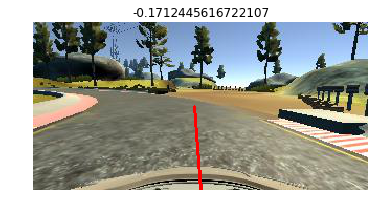

In [133]:
draw_prediction(27)
print(steer[27])

0.0


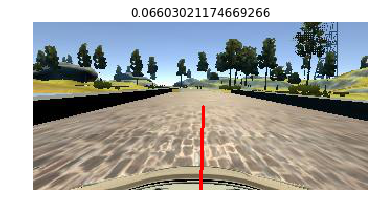

In [137]:
draw_prediction(0)
print(steer[0])

0.0


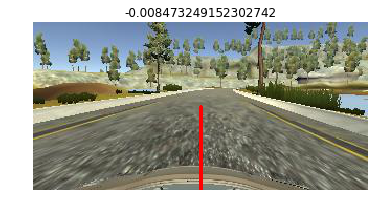

In [138]:
draw_prediction(1000)
print(steer[1000])

0.0


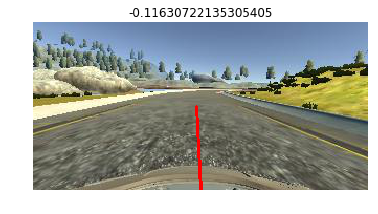

In [139]:
draw_prediction(8000)
print(steer[8000])